# VIX Cross Asset Volatility with Dispersion

# Packages

In [1]:
import os
import pdblp
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas_datareader as web

import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

# Path Management

In [2]:
parent_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_path = os.path.join(parent_path, "data")
out_path = os.path.join(parent_path, "out")

if os.path.exists(data_path) == False: os.makedirs(data_path)
if os.path.exists(out_path) == False: os.makedirs(out_path)

FIGSIZE# Read Data
See collect_data.py for data collection, collect the following data
1. All of the Generic Treasury yields available for UST
2. MOVE Index
3. VIX Index
4. Implied Correlation Index

In [3]:
FIGSIZE = (16, 6)

In [4]:
df_yf = pd.read_parquet(
    path = os.path.join(data_path, "yf.parquet"),
    engine = "pyarrow")

df_fred = pd.read_parquet(
    path = os.path.join(data_path, "fred.parquet"),
    engine = "pyarrow")

df_corr = pd.read_parquet(
    path = os.path.join(data_path, "corr.parquet"))

df_spx = pd.read_parquet(
    path = os.path.join(data_path, "spx_names.parquet"))

df_skew = pd.read_parquet(
    path = os.path.join(data_path, "skew.parquet"))

## Incorporate Dispersion into our measure

In [19]:
df_vol_corr = (df_yf.query(
    "variable == 'VIX'").
    rename(columns = {
        "variable": "volatility_ticker",
        "value": "volatility_measure"}).
    merge(
        df_corr, how = "inner", on = ["date"]).
    rename(columns = {
        "ticker": "corr_ticker",
        "value": "corr_measure"}).
    drop(columns = ["field"]).
    assign(vol_corr = lambda x: x.volatility_measure / (x.corr_measure / 100)).
    set_index("date"))

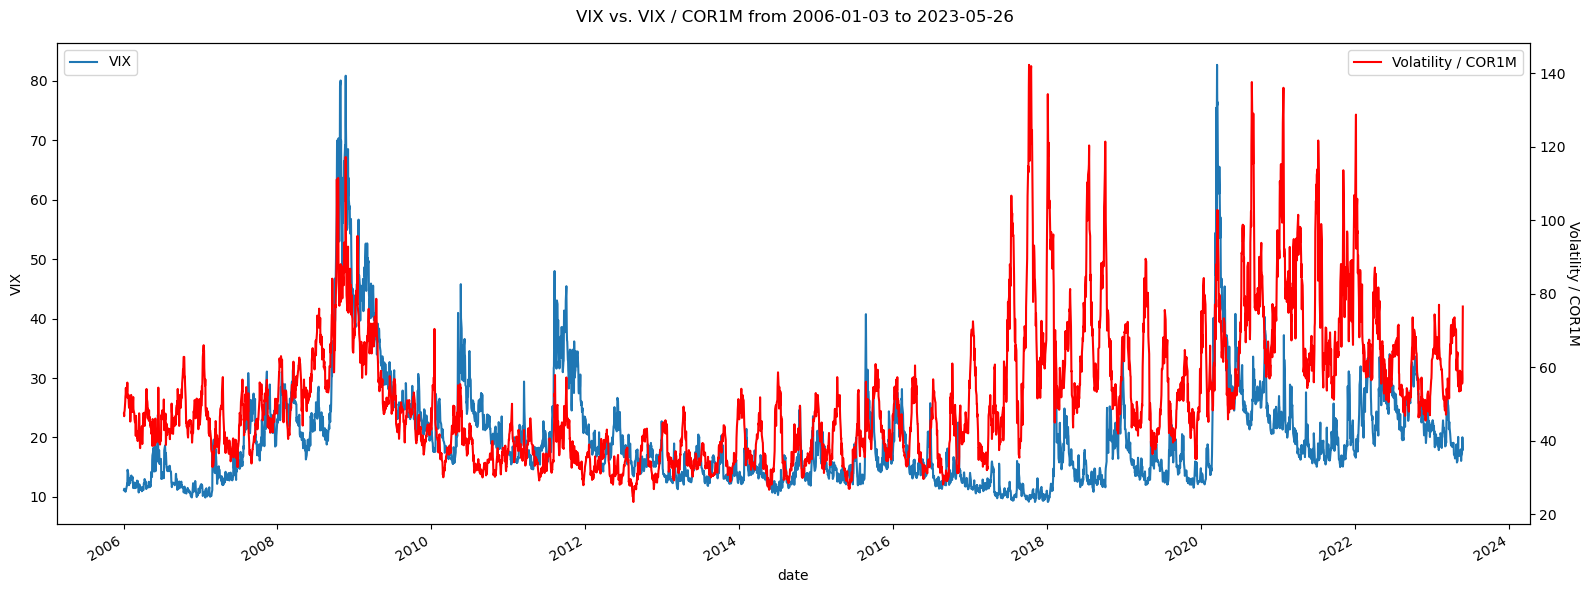

In [20]:
fig, axes = plt.subplots(figsize = FIGSIZE)
axes_copy = axes.twinx()

(df_vol_corr[[
    "volatility_measure"]].
    rename(columns = {"volatility_measure": "VIX"}).
    plot(ax = axes, ylabel = "VIX", label = "VIX"))

(df_vol_corr[
    ["vol_corr"]].
    rename(columns = {"vol_corr": "Volatility / COR1M"}).
    plot(ax = axes_copy, color = "red"))

axes_copy.set_ylabel("Volatility / COR1M", rotation = 270, labelpad = 10)
axes_copy.legend(loc = "upper right")
axes.legend(loc = "upper left")

fig.suptitle("VIX vs. VIX / COR1M from {} to {}".format(
    df_vol_corr.index.min().date(),
    df_vol_corr.index.max().date()))

plt.tight_layout()
plt.savefig(os.path.join(out_path, "vix_corr.jpeg"), dpi = 150)
plt.show()

In [21]:
df_corr_move = (df_vol_corr[
    ["vol_corr"]].
    reset_index().
    assign(name = "VIX/COR1M").
    pivot(index = "date", columns = "name", values = "vol_corr").
    reset_index().
    merge(df_yf_prep, how = "left", on = ["date"]).
    set_index("date"))

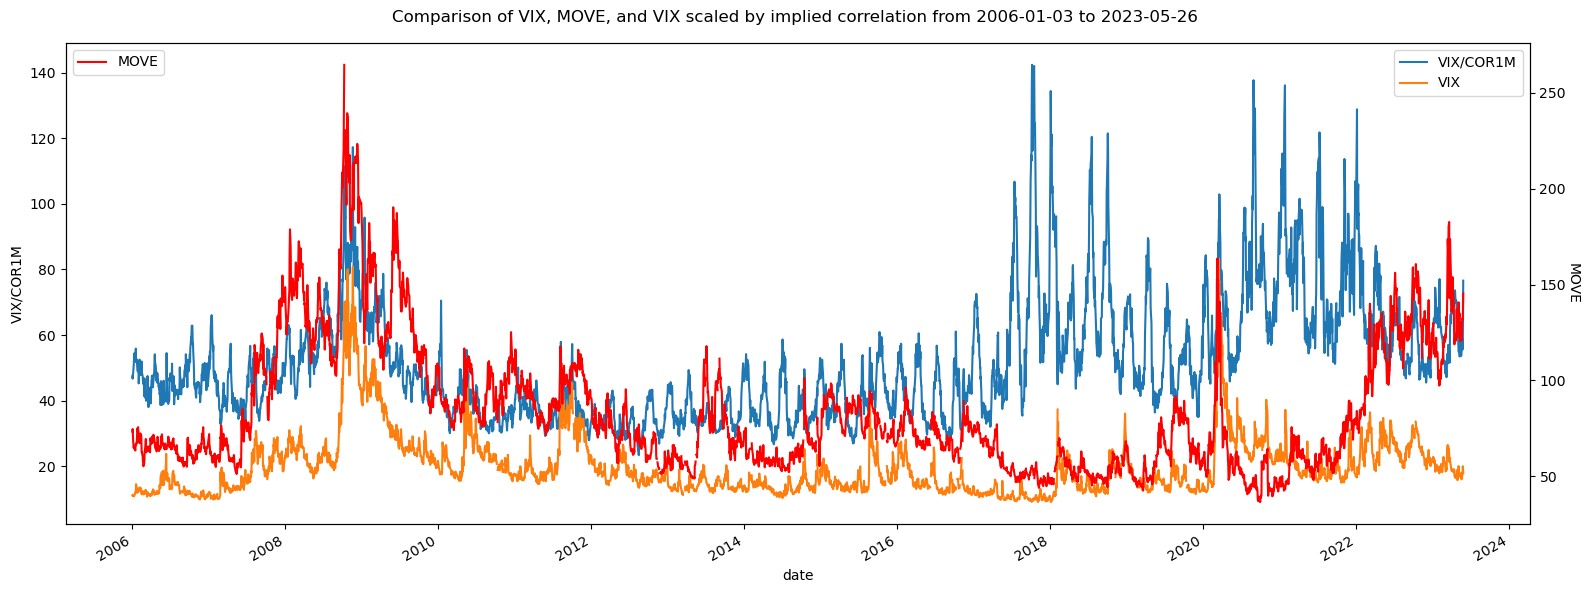

In [22]:
fig, axes = plt.subplots(figsize = FIGSIZE)

(df_corr_move[
    ["VIX/COR1M", "VIX"]].
    plot(
        ax = axes,
        ylabel = "VIX/COR1M"))

axes_twin = axes.twinx()
(df_corr_move[
    ["MOVE"]].
    plot(
        ax = axes_twin,
        color = "r"))
axes_twin.set_ylabel("MOVE", rotation = 270, labelpad = 10)
axes_twin.legend(loc = "upper left")

fig.suptitle("Comparison of VIX, MOVE, and VIX scaled by implied correlation from {} to {}".format(
    df_corr_move.index.min().date(), df_corr_move.index.max().date()))
plt.tight_layout()

Let's look at their rolling z-scores

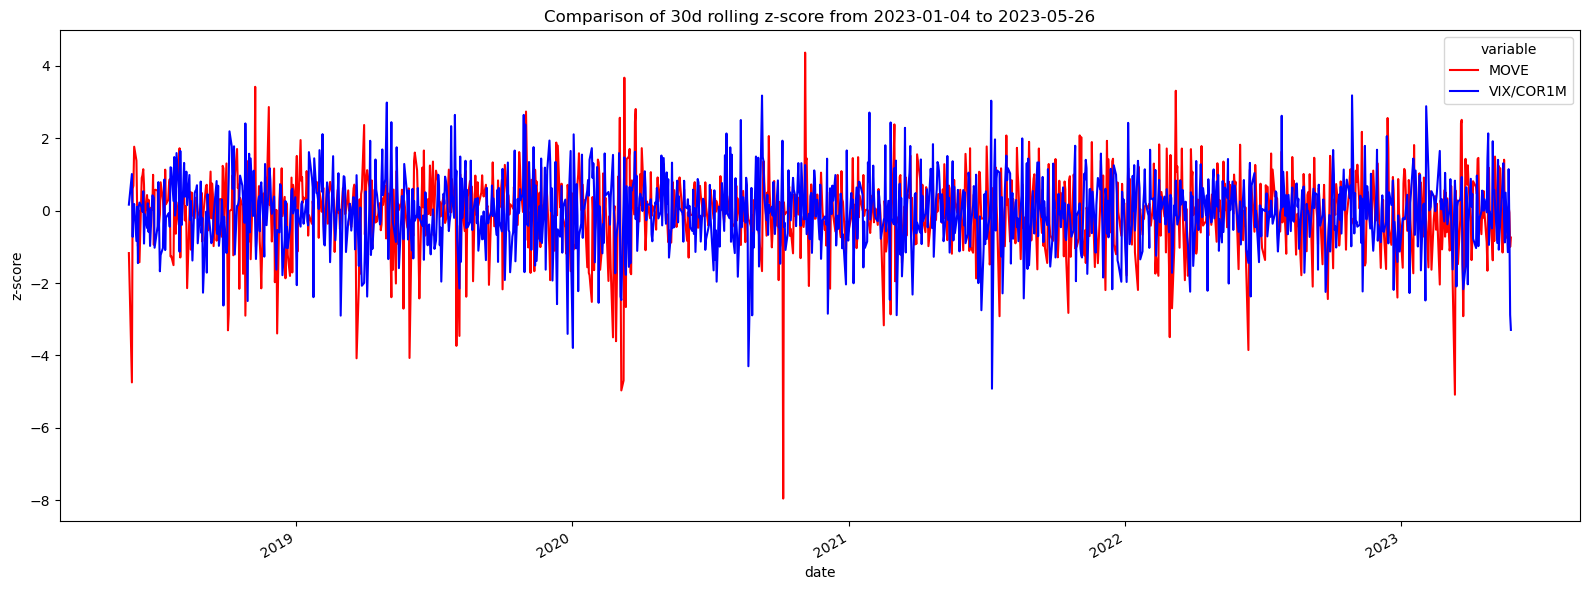

In [23]:
df_corr_z_score = (df_corr_move.drop(
    columns = ["VIX"]).
    reset_index().
    melt(id_vars = "date").
    groupby("variable").
    apply(_get_z_score).
    drop(columns = ["value"]).
    pivot(index = "date", columns = "variable", values = "z_score"))

df_corr_z_score_tail = df_corr_z_score.tail(252 * 5)

fig, axes = plt.subplots(figsize = FIGSIZE)
(df_corr_z_score_tail.plot(
    ax = axes,
    color = ["red", "blue"],
    ylabel = "z-score",
    title = "Comparison of 30d rolling z-score from {} to {}".format(
        df_z_score_tail.index.min().date(),
        df_z_score_tail.index.max().date())))

plt.tight_layout()
fig.savefig(os.path.join(out_path, "vix_corr_move_z_score.jpeg"))

Text(0.5, 0.98, 'Difference between VIX and MOVE 30d Z-Scores from 2006-06-26 to 2023-05-26')

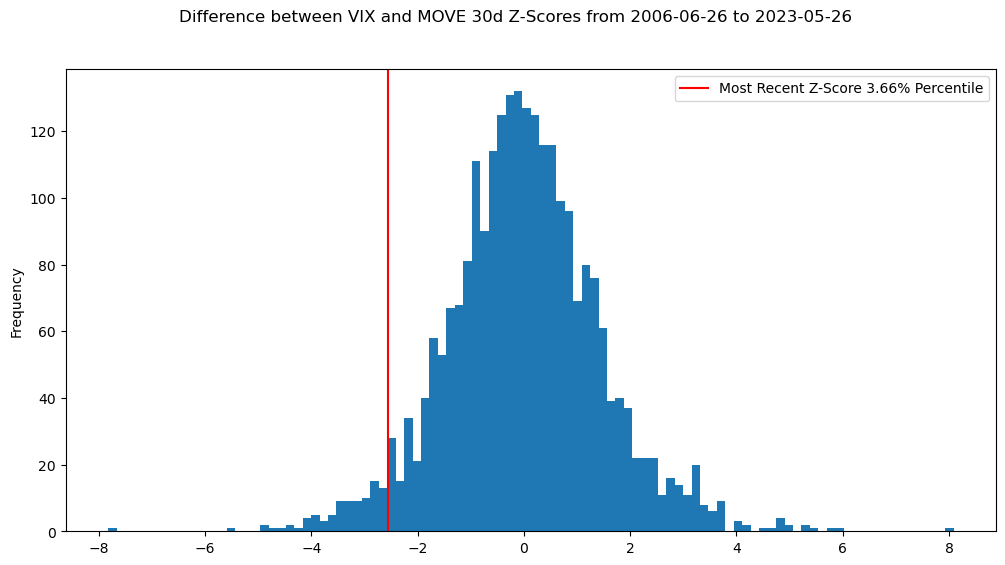

In [24]:
df_corr_z_score = (df_corr_z_score.dropna().rename(
    columns = {"VIX/COR1M": "vix_corr"}).
    assign(diff = lambda x: x.vix_corr - x.MOVE)
    [["diff"]])

last_z_score = df_corr_z_score.reset_index().query("date == date.max()")["diff"].values[0]
percentile = stats.percentileofscore(df_corr_z_score["diff"].values, last_z_score)

fig, axes = plt.subplots(figsize = (12, 6))
axes.axvline(last_z_score, color = "red", label = "Most Recent Z-Score {}% Percentile".format(
    round(percentile,2)))

axes.legend()
df_corr_z_score.tail(252 * 10).plot(
    kind = "hist", bins = 100,
    ax = axes, legend = False)

fig.suptitle("Difference between VIX and MOVE 30d Z-Scores from {} to {}".format(
    df_corr_z_score.index.min().date(),
    df_corr_z_score.index.max().date()))

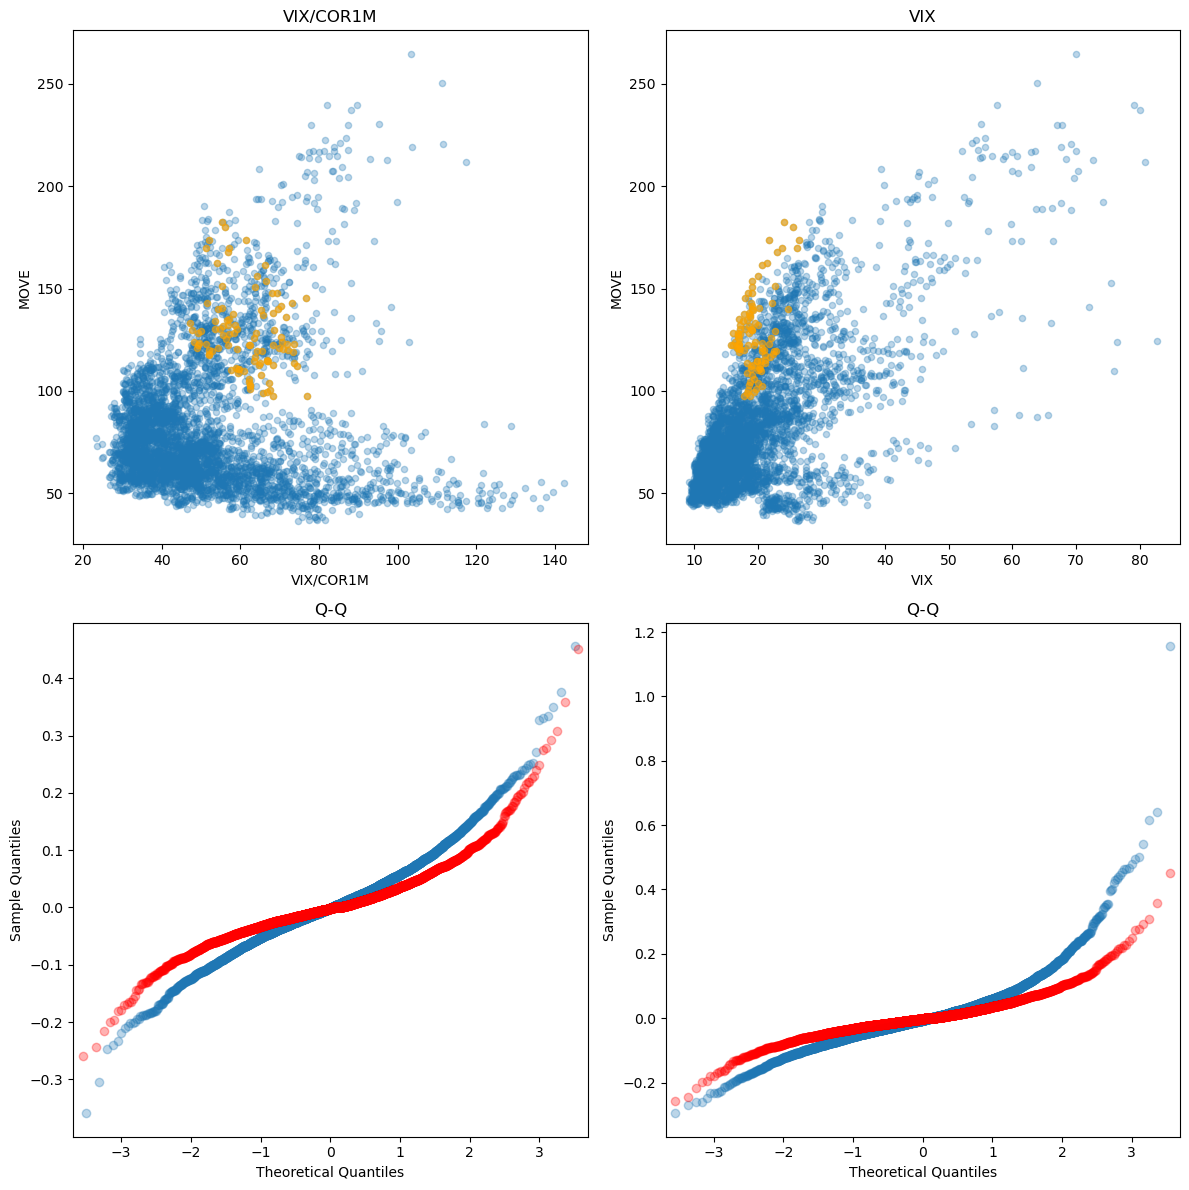

In [25]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 12))

(df_corr_move[
    ["VIX/COR1M", "MOVE"]].
    plot(
        ax = axes[0,0], kind = "scatter",
        x = "VIX/COR1M", y = "MOVE",
        alpha = 0.3))

(df_corr_move[
    ["VIX/COR1M", "MOVE"]].
    tail(100).
    plot(
        ax = axes[0,0], kind = "scatter",
        x = "VIX/COR1M", y = "MOVE",
        color = "orange", alpha = 0.6))

(df_corr_move[
    ["VIX", "MOVE"]].
    plot(
        ax = axes[0,1], kind = "scatter",
        x = "VIX", y = "MOVE",
        alpha = 0.3))

(df_corr_move[
    ["VIX", "MOVE"]].
    tail(100).
    plot(
        ax = axes[0,1], kind = "scatter",
        x = "VIX", y = "MOVE",
        color = "orange", alpha = 0.6))

_ = sm.qqplot(
    df_yf_wider.VIX,
    ax = axes[1,1],
    alpha = 0.3,
    label = "VIX")

_ = sm.qqplot(
    df_yf_wider.MOVE,
    markerfacecolor = "r",
    markeredgecolor = "r",
    alpha = 0.3,
    ax = axes[1,1],
    label = "MOVE")

_ = sm.qqplot(
    df_corr_move["VIX/COR1M"].pct_change().dropna(),
    alpha = 0.3,
    ax = axes[1,0],
    label = "VIX/COR1M")

_ = sm.qqplot(
    df_yf_wider.MOVE,
    markerfacecolor = "r",
    markeredgecolor = "r",
    alpha = 0.3,
    ax = axes[1,0],
    label = "MOVE")

axes[0,0].set_title("VIX/COR1M")
axes[0,1].set_title("VIX")
axes[1,0].set_title("Q-Q")
axes[1,1].set_title("Q-Q")

plt.tight_layout()

## Do change in an as well

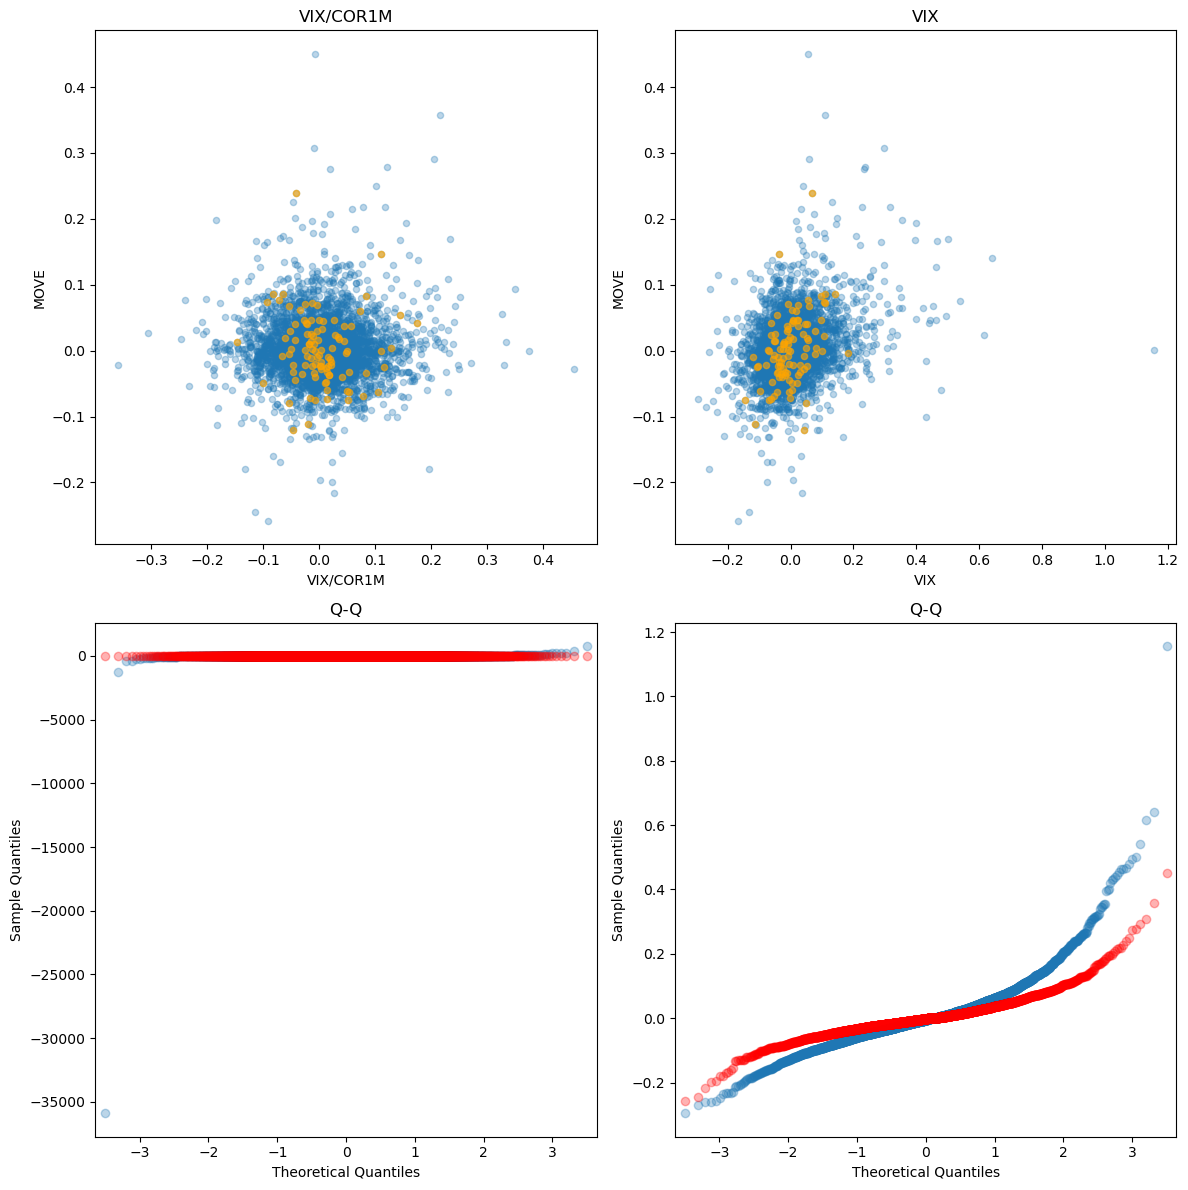

In [32]:
df_vix_change = df_corr_move.pct_change().dropna()


fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 12))

(df_vix_change[
    ["VIX/COR1M", "MOVE"]].
    plot(
        ax = axes[0,0], kind = "scatter",
        x = "VIX/COR1M", y = "MOVE",
        alpha = 0.3))

(df_vix_change[
    ["VIX/COR1M", "MOVE"]].
    tail(100).
    plot(
        ax = axes[0,0], kind = "scatter",
        x = "VIX/COR1M", y = "MOVE",
        color = "orange", alpha = 0.6))

(df_vix_change[
    ["VIX", "MOVE"]].
    plot(
        ax = axes[0,1], kind = "scatter",
        x = "VIX", y = "MOVE",
        alpha = 0.3))

(df_vix_change[
    ["VIX", "MOVE"]].
    tail(100).
    plot(
        ax = axes[0,1], kind = "scatter",
        x = "VIX", y = "MOVE",
        color = "orange", alpha = 0.6))

_ = sm.qqplot(
    df_vix_change.VIX,
    ax = axes[1,1],
    alpha = 0.3,
    label = "VIX")

_ = sm.qqplot(
    df_vix_change.MOVE,
    markerfacecolor = "r",
    markeredgecolor = "r",
    alpha = 0.3,
    ax = axes[1,1],
    label = "MOVE")

_ = sm.qqplot(
    df_vix_change["VIX/COR1M"].pct_change().dropna(),
    alpha = 0.3,
    ax = axes[1,0],
    label = "VIX/COR1M")

_ = sm.qqplot(
    df_vix_change.MOVE,
    markerfacecolor = "r",
    markeredgecolor = "r",
    alpha = 0.3,
    ax = axes[1,0],
    label = "MOVE")

axes[0,0].set_title("VIX/COR1M")
axes[0,1].set_title("VIX")
axes[1,0].set_title("Q-Q")
axes[1,1].set_title("Q-Q")

plt.tight_layout()

# VIX vs. SKEW Index

If we look at the skew of the 

In [26]:
df_join = (df_yf_prep.reset_index().
    merge(
        (df_skew[
            ["date", "value"]].
            rename(columns = {"value": "SKEW"})),
        how = "inner",
        on = ["date"]).
    set_index("date"))

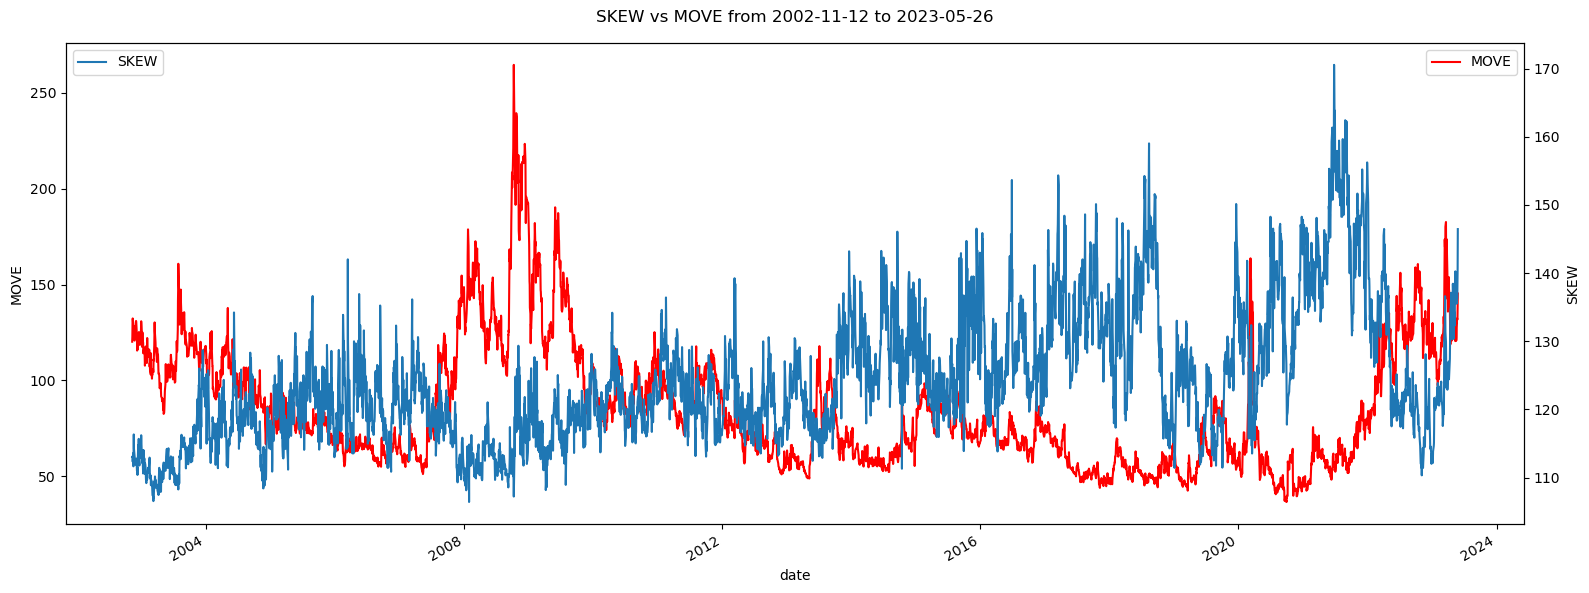

In [27]:
fig, axes = plt.subplots(figsize = FIGSIZE)

(df_join[
    ["MOVE"]].
    plot(
        ax = axes,
        color = "r",
        ylabel = "MOVE"))

axes_copy = axes.twinx()

(df_join[
    ["SKEW"]].
    plot(
        ylabel = "SKEW",
        ax = axes_copy))

axes_copy.legend(loc = "upper left")
axes.legend(loc = "upper right")

fig.suptitle("SKEW vs MOVE from {} to {}".format(
    df_join.index.min().date(), df_join.index.max().date()))
plt.tight_layout()
plt.show()

Let's compare the skew vs. MOVE and then compare VIX + SKEW vs MOVE

In [33]:
df_skew_combined = (df_join.assign(
    combined = lambda x: (0.5 + x.VIX) + (0.5 * x.SKEW)))

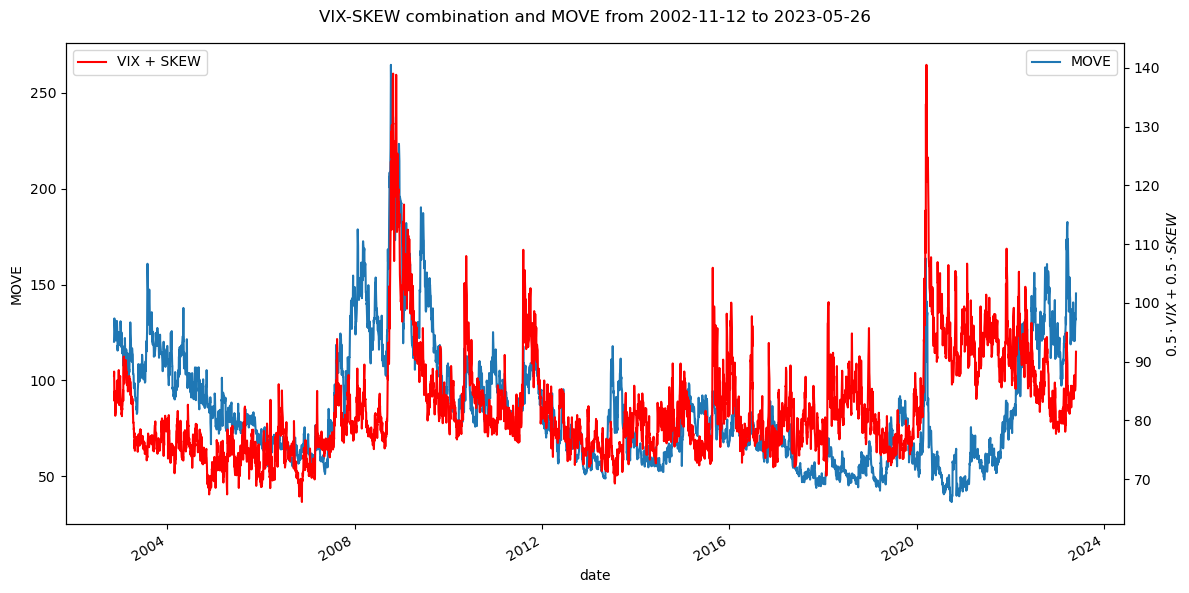

In [46]:
fig, axes = plt.subplots(figsize = (12, 6))

(df_skew_combined[
    ["MOVE"]].
    plot(
        ax = axes,
        ylabel = "MOVE"))

axes_copy = axes.twinx()
(df_skew_combined[
    ["combined"]].
    rename(columns = {"combined": "VIX + SKEW"}).
    plot(
        ax = axes_copy,
        ylabel = "$0.5 \cdot VIX + 0.5 \cdot SKEW$",
        color = "r"))

axes_copy.legend(loc = "upper left")
axes.legend(loc = "upper right")

fig.suptitle("VIX-SKEW combination and MOVE from {} to {}".format(
    df_skew_combined.index.min().date(),
    df_skew_combined.index.max().date()))

plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='combined', ylabel='MOVE'>

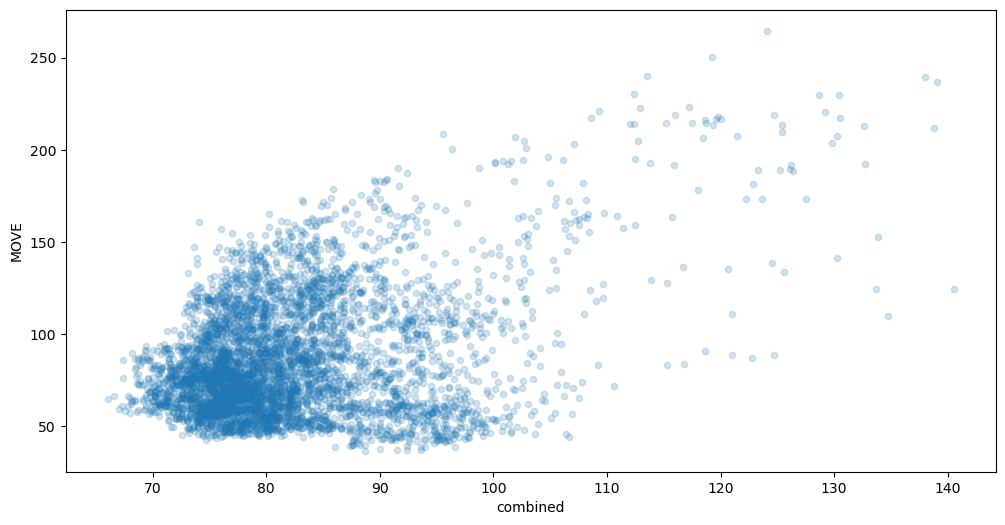

In [49]:
(df_skew_combined.plot(
    kind = "scatter", x = "combined", y = "MOVE",
    figsize = (12, 6),
    alpha = 0.2))